In [4]:
!pip install torch pillow transformers peft datasets lightning wandb nltk bitsandbytes accelerate bert-score -q

## Training

In [5]:
from datasets import load_dataset, Image
from PIL import Image as PILImage

from transformers import Idefics3ForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel

import torch
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

import re
from nltk import edit_distance
import numpy as np
import requests
import io
from bert_score import score as bert_score

from huggingface_hub import HfApi
from huggingface_hub import notebook_login

notebook_login()

MAX_LENGTH = 256

MODEL_ID = "HuggingFaceTB/SmolVLM-Base"
REPO_ID = "AndresSebad/smol-vlm-memes-chilenos-small"
DATASET_ID = "AndresSebad/memes_instagram_chilenos_es_small"

WANDB_PROJECT = "SmolVLMMemes"
WANDB_NAME = "smol-vlm-memes_chilenos_small"
WANDB_KEY = "90e0053adedf3ef5d182a9ca5142acebe91158ff"

In [2]:
import wandb

wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc
wandb: Currently logged in as: andres-seba-ai (andres-seba-ai-uc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
ds = load_dataset(DATASET_ID, trust_remote_code=True)
split_ds = ds['train']

def preprocess(dataset):
    dataset = dataset.add_column("question", ["Explica este meme como lo haría un chileno."] * len(dataset))
    cols_to_keep = ["image", "multiple_choice_answer", "question"]
    dataset = dataset.remove_columns([c for c in dataset.column_names if c not in cols_to_keep])
    return dataset

train_ds = preprocess(split_ds)
train_ds = train_ds.cast_column("image", Image(decode=True))
def resize_batch(examples):
    examples["image"] = [img.resize((336, 336)) for img in examples["image"]]
    return examples

# Los dejamos en 336x336 pixeles
train_ds = train_ds.map(resize_batch, batched=True)

README.md:   0%|          | 0.00/366 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [5]:
splits = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds = splits['train'] 
val_ds  = splits['test']

In [6]:
train_ds, val_ds

(Dataset({
     features: ['image', 'multiple_choice_answer', 'question'],
     num_rows: 630
 }),
 Dataset({
     features: ['image', 'multiple_choice_answer', 'question'],
     num_rows: 70
 }))

In [7]:
processor = AutoProcessor.from_pretrained(
    MODEL_ID
)

image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.05k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

In [7]:
model = Idefics3ForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16
    )

In [9]:
lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        init_lora_weights="gaussian"
)

model = get_peft_model(model, lora_config)

In [10]:
class SmolVLMDataset(Dataset):
    def __init__(
        self,
        dataset = None
    ):
        super().__init__()
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int):
        sample = self.dataset[idx]
        image = sample["image"]
        target_sequence = sample["multiple_choice_answer"]
        return image, target_sequence

In [11]:
train_dataset = SmolVLMDataset(dataset=train_ds)
val_dataset = SmolVLMDataset(dataset=val_ds)

In [14]:
val_example = val_dataset[0]

image, target_sequence = val_example

print(target_sequence)

Ya, mira, este meme es una talla clásica sobre cómo percibimos las cosas de manera súper diferente. Es como cuando una mina que es toda aesthetic te invita a su pieza, y ella la ve como un lugar bacán, lleno de color rosado, peluches, y toda la onda kawaii, ¿cachái? Pero, uno la ve y se siente como en una celda acolchada de un psiquiátrico, todo blanco y vacío, como para volverse loco.


In [15]:
def train_collate_fn(examples):
    images, ground_truths = zip(*examples)

    prompts = []
    for gt in ground_truths:
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Si hay texto en la imagen, entiende su significado sin repetirlo. Observa también la imagen. Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."},
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": gt},
                ],
            }
        ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=False)
        prompts.append(prompt)

    batch = processor(
        text=prompts,
        images=list(images),
        return_tensors="pt",
        padding=True
    )

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return (
        batch["input_ids"],
        batch["attention_mask"],
        batch["pixel_values"],
        batch["labels"],
    )

def eval_collate_fn(examples):
    images, ground_truths = zip(*examples)

    prompts = []
    for _ in ground_truths:
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Si hay texto en la imagen, entiende su significado sin repetirlo. Observa también la imagen. Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."},
                ],
            }
        ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=False)
        prompts.append(prompt)

    batch = processor(
        text=prompts,
        images=list(images),
        return_tensors="pt",
        padding=True
    )

    return (
        batch["input_ids"],
        batch["attention_mask"],
        batch["pixel_values"],
        list(ground_truths),
    )

In [16]:
class SmolModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            pixel_values=pixel_values,
                            labels=labels
                          )
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def on_validation_start(self):
        self.n_val_printed = 0  # Reiniciamos contador de la validación

    #def validation_step(self, batch, batch_idx, dataset_idx=0):
    #    input_ids, attention_mask, pixel_values, image_sizes, answers = batch
    #
    #    generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
    #                                   pixel_values=pixel_values, image_sizes=image_sizes, max_new_tokens=MAX_LENGTH)
    #    predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)
    #
    #    scores = []
    #    for pred, answer in zip(predictions, answers):
    #        scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))
    #
    #        if self.config.get("verbose", False) and self.n_val_printed < 2:
    #            print(f"Prediction: {pred}")
    #            print(f"    Answer: {answer}")
    #            print(f" Normed ED: {scores[0]}")
    #            self.n_val_printed += 1 # Asi imprimimos solo dos ejemplos
    #
    #    self.log("val_edit_distance", np.mean(scores))
    #
    #    return scores

    def validation_step(self, batch):
        input_ids, attention_mask, pixel_values, answers = batch
    
        generated_ids = self.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            max_new_tokens=MAX_LENGTH
        )
    
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)
    
        # EDIT DISTANCE
        ed_scores = []
        for pred, answer in zip(predictions, answers):
            ed_scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))
    
        self.log("val_edit_distance", np.mean(ed_scores))
    
        # BERTScore
        P, R, F1 = bert_score(predictions, answers, lang="es", verbose=False)
        mean_f1 = F1.mean().item()
        self.log("val_bertscore_f1", mean_f1, prog_bar=True)
    
        # Verbose ejemplos
        if self.config.get("verbose", False) and self.n_val_printed < 2:
            print(f"Prediction: {predictions[0]}")
            print(f"    Answer: {answers[0]}")
            print(f" Normed ED: {ed_scores[0]}")
            print(f" BERTScore F1: {F1[0].item():.4f}")
            self.n_val_printed += 1
    
        return {"edit_distance": np.mean(ed_scores), "bertscore_f1": mean_f1}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [17]:
config = {"max_epochs": 10,
          "val_check_interval": 0.5,
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 16,
          "lr": 1e-4,
          "batch_size": 1,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
          "num_workers": 4
}

model_module = SmolModelPLModule(config, processor, model)

In [18]:
api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Subiendo modelo a Hub en HF, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Entrenamiento en Progreso, epoch {trainer.current_epoch}")
    def on_train_end(self, trainer, pl_module):
        print(f"Subiendo modelo y procesador a Hub en HF")
        pl_module.processor.push_to_hub(REPO_ID,
                                    commit_message=f"Entrenamiento Terminado.")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Entrenamiento Terminado.")

early_stop_callback = EarlyStopping(monitor="val_bertscore_f1", patience=3, verbose=False, mode="max")

In [ ]:
%%time

wandb_logger = WandbLogger(
    project=WANDB_PROJECT
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_bertscore_f1",  
    mode="max",                   
    save_top_k=1,                 
    verbose=True,
    filename="best-checkpoint-{epoch:02d}-{val_bertscore_f1:.4f}"
)

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=70,
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[
            #PushToHubCallback(),
            early_stop_callback,
            checkpoint_callback
        ],
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 2.3 B  | train
--------------------------------------------
10.5 M    Trainable params
2.2 B     Non-trainable params
2.3 B     Total params
9,027.239 Total estimated model params size (MB)
2492      Modules in train mode
654       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Prediction: Background: The image shows a bed with a cat on it and a white wall with pink squares.
    Answer: Ya, mira, este meme es una talla clásica sobre cómo percibimos las cosas de manera súper diferente. Es como cuando una mina que es toda aesthetic te invita a su pieza, y ella la ve como un lugar bacán, lleno de color rosado, peluches, y toda la onda kawaii, ¿cachái? Pero, uno la ve y se siente como en una celda acolchada de un psiquiátrico, todo blanco y vacío, como para volverse loco.
 Normed ED: 0.8530927835051546
 BERTScore F1: 0.6516
Prediction: Assistant: En este meme, se dice que hay que ser más inteligible
    Answer: Jajaja, este meme es típico de cuando se viene el Año Nuevo y uno ya sabe que la cosa se va a poner buena. Básicamente, el compadre está diciendo que prefiere desear feliz año ahora mismo porque en la noche va a estar medio pasado de copas, o sea, curado. Es como asumir que la celebración va a ser potente y mejor asegurarse con los buenos deseos antes de q


Detected KeyboardInterrupt, attempting graceful shutdown ...


### Save Best Model

In [41]:
checkpoint = trainer.checkpoint_callback.best_model_path

In [43]:
checkpoint

'./LLaVaNeXTMemes/5vkvok30/checkpoints/best-checkpoint-epoch=01-val_edit_distance=0.69.ckpt'

In [44]:
model_module = SmolModelPLModule.load_from_checkpoint(
    checkpoint,
    config=config,
    processor=processor,
    model=model
)

In [45]:
model_module.model.push_to_hub(REPO_ID, commit_message=f"Mejor modelo subido a HF.")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/88.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small/commit/11c92b0e4781c1f99feafe948a329c94fa98aa72', commit_message='Mejor modelo subido a HF.', commit_description='', oid='11c92b0e4781c1f99feafe948a329c94fa98aa72', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small', endpoint='https://huggingface.co', repo_type='model', repo_id='AndresSebad/llava-v1.6-mistral-7b-memes-chilenos-small'), pr_revision=None, pr_num=None)

## Test

In [46]:
model_nuevo = Idefics3ForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16
)

model_nuevo = PeftModel.from_pretrained(model_nuevo, "AndresSebad/smol-vlm-memes-chilenos-small")
model_nuevo = model_nuevo.to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/88.7M [00:00<?, ?B/s]

In [47]:
processor = AutoProcessor.from_pretrained(MODEL_ID)

model_original = Idefics3ForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16
).to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
URL_INSTAGRAM = """
https://instagram.fscl35-1.fna.fbcdn.net/v/t51.2885-15/491449152_18265505524275313_1039743486705849431_n.webp?efg=eyJ2ZW5jb2RlX3RhZyI6IkZFRUQuaW1hZ2VfdXJsZ2VuLjE0NDB4MTQ0MC5zZHIuZjc1NzYxLmRlZmF1bHRfaW1hZ2UifQ&_nc_ht=instagram.fscl35-1.fna.fbcdn.net&_nc_cat=101&_nc_oc=Q6cZ2QE12rCQgLnMKGV9K7FcDjB-RxnZJD2sTb8pefszwyJ57SO-LUBJVpEvmNiSjWlHWbA&_nc_ohc=J6-I7YA1Jx4Q7kNvwFYDUci&_nc_gid=YxKQWTDQ_TW12X4XYuexZw&edm=APoiHPcBAAAA&ccb=7-5&ig_cache_key=MzYyMTQ5NDY3MzMyODY2NjA4Mg%3D%3D.3-ccb7-5&oh=00_AfH-op5otNpDhjIW2mVA0Bw696QB4IusU7zizUqUW_TSzA&oe=681B813A&_nc_sid=22de04
"""
# Descargar la imagen HEIC en memoria
try:
    resp = requests.get(URL_INSTAGRAM)
    resp.raise_for_status()
    img_bytes = io.BytesIO(resp.content)
    img = PILImage.open(img_bytes)
    img = img.convert('RGB')
    img = img.resize((336, 336))
except requests.exceptions.RequestException as e:
    print(f"Error al descargar la imagen: {e}")

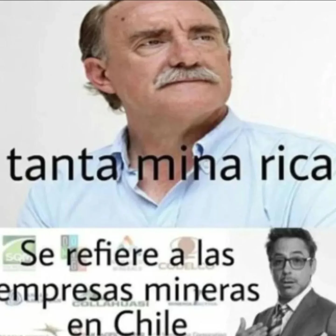

In [60]:
img

In [61]:
conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Si hay texto en la imagen, entiende su significado sin repetirlo. Observa también la imagen. Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."},
                ],
            }
]

text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
batch = processor(text=text_prompt, images=[img], return_tensors="pt").to("cuda")

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
pixel_values = batch["pixel_values"]

In [62]:
generated_ids_original = model_original.generate(input_ids=input_ids, attention_mask=attention_mask,
                                    pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [63]:
generated_ids_nuevo = model_nuevo.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pixel_values=pixel_values,
    max_new_tokens=MAX_LENGTH,
    #no_repeat_ngram_size=3         # evita repetir frases de 3 palabras
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [64]:
predictions_original = processor.batch_decode(generated_ids_original[:, input_ids.size(1):], skip_special_tokens=True)
predictions_nuevo = processor.batch_decode(generated_ids_nuevo[:, input_ids.size(1):], skip_special_tokens=True)

In [65]:
predictions_original[0]

'Este meme en Chile se refiere a las empresas mineras en Chile, que son una parte importante de la economía del país. La frase "tanta mina rica" es una expresión coloquial que se utiliza para describir a alguien que es muy rico o tiene mucho dinero.\n\nEn este meme, se utiliza la expresión para describir a las empresas mineras, sugeriendo que estas empresas tienen mucho dinero y que están muy ricas. La imagen de un hombre con una barba y una camisa blanca, que se utiliza como un logotipo, es una forma de representar a las empresas mineras, que a menudo son dirigidas por hombres de negocios con una apariencia similar.\n\nLa frase "Se refiere a las empresas mineras en Chile" indica que el meme está relacionado con la industria minera en Chile, que es una de las principales fuentes de ingresos del país. La frase "en Chile" es una forma de especificar que el mem'

In [66]:
predictions_nuevo[0]

'Este meme está buenísimo, mezcla humor absurdo con crítica social. Aparece el expresidente Boric con cara seria, y el texto dice: "Tan mina rica, se refiere a las empresas mineras en Chile". La talla va directo al poder y la influencia de las empresas mineras en el país, como si estuvieran tratando de controlar todo.'